# Pytorch Tutoral - Autograd & MLP(Multi-layer perceptron)

# Autograd

- `autograd`패키지는 텐서의 모든 연산에 대한 자동 미분을 제공
- 실행-기반-정의(define-by-run) 프레임워크로, 코드를 어떻게 작성하여 실행하느냐에 따라 역전파가 정의된다는 것을 의미
- 역전파는 학습 과정의 매 단계마다 달라짐


## Tensor

- `torch.Tensor` 클래스의 `.requires_grad` 속성을 `True`로 설정하면, 해당 텐서에서 이루어진 모든 연산을 추적(track)하기 시작
- 계산이 완료된 후 `.backward()`를 호출하여 모든 변화도(gradient)를 자동으로 계산할 수 있으며 이 Tensor의 변화도는 `.grad` 속성에 누적됨
- Tensor가 기록을 추적하는 것을 중단하게 하려면, `.detach()`를 호출하여 연산기록으로부터 분리하여 연산이 추적되는 것을 방지할 수 있음
- 기록을 추적하는 것(과 메모리를 사용하는 것)을 방지하기 위해서 코드 블럭을 `with torch.no_grad():`로 감쌀 수 있음
- 이는 변화도(gradient)는 필요 없지만 `requires_grad=True`가 설정되어 학습 가능한 매개변수를 갖는 모델을 평가(evaluate)할 때 유용
- Autograd 구현에서 `Function` 클래스는 매우 중요한 역할을 수행
- `Tensor`와 `Function`은 서로 연결되어 있고 모든 연산 과정을 부호화하여 순환하지 않는 그래프를 생성
- 각 tensor는 `.grad_fn` 속성을 가지고 있는데 이는 `Tensor`를 생성한 `Function`을 참조함(단, 사용자가 만든 Tensor는 예외이며, 사용자가 만든 Tensor가 아닌 연산에 의해 생긴 텐서와 같은 경우는 모두 `Function`을 참조)
- 도함수를 계산하기 위해서는 `Tensor`의 `.backward()`를 호출하면 됨

In [ ]:
import torch

print(torch.__version__)

1.12.1+cu113


In [ ]:
# x의 연산 과적을 추적하기 위해 requires_grad=True로 설정
x = torch.ones(2, 2, requires_grad=True)
print(x)

# 직접 생선한 Tensor이기 때문에 grad_fn이 None인 것을 확인할 수 있음
print(x.grad_fn)

tensor([[1., 1.],
        [1., 1.]], requires_grad=True)
None


In [ ]:
# y는 연산의 결과로 생성된 것이기 때문에 grad_fn을 갖고 있는 것을 확인 가능
y = x + 2
print(y)

tensor([[3., 3.],
        [3., 3.]], grad_fn=<AddBackward0>)


In [ ]:
# 연산의 결과로 생성된 것이기 때문에 grad_fn을 갖는 것을 확인 가능
print(y.grad_fn)

In [ ]:
z = y * y * 3
out = z.mean()

# 각각 사용한 func에 맞게 grad_fn이 생성된 것을 확인할 수 있음
print(z)
print(out)

tensor([[27., 27.],
        [27., 27.]], grad_fn=<MulBackward0>)
tensor(27., grad_fn=<MeanBackward0>)


- `requires_grad_()`를 사용하면 기존 Tensor의 `requires_grad` 값을 바꿀 수 있음
- 입력 값이 지정되지 않으면 기본 값은 `False`

In [ ]:
a = torch.randn(2, 2)
print(a)

tensor([[ 0.3018,  0.0148],
        [ 0.6419, -0.3544]])


In [ ]:
a = ((a * 3) / (a - 1))
print(a)
print(a.requires_grad)

tensor([[-1.2968, -0.0450],
        [-5.3774,  0.7851]])
False


In [ ]:
a.requires_grad_(True)

tensor([[-1.2968, -0.0450],
        [-5.3774,  0.7851]], requires_grad=True)

In [ ]:
print(a.requires_grad)

True


In [ ]:
b = (a * a).sum()
print(b)
print(b.requires_grad)

tensor(31.2167, grad_fn=<SumBackward0>)
True


## 변화도(Gradient)


In [ ]:
print(out)

# 이전에 만든 out을 사용해서 역전파 진행
# 여러번 역전파를 하기위해서는 retain_graph=True로 지정
out.backward(retain_graph=True)
# out.backward(torch.tensor(1.))을 진행하는 것과 동일

tensor(27., grad_fn=<MeanBackward0>)


RuntimeError: ignored

In [ ]:
# 역전파를 진행한 후의 x값
# d(out) / dx 
print(x.grad)
print(y.grad)
print(z.is_leaf)

tensor([[4.5000, 4.5000],
        [4.5000, 4.5000]])
tensor([[4.5000, 4.5000],
        [4.5000, 4.5000]])
False


$$ out = \frac{1}{4} \sum_{i} z_i $$
$$ z_i = 3(x_i + 2)^2 $$
- `z_i`를 미분한 값에 적용하면 4.5를 동일하게 출력할 수 있음






out(미분결과) = 1/4 * 6 * (x + 2) = 3/2(x+2) 



---




- 일반적으로 `torch.autograd`는 벡터-야코비안 곱을 계산하는 엔진
- `torch.autograd`를 사용하면 전체 야코비안을 직접 계산할 수는 없지만, 벡터-야코비안 곱은 `backward`에 해당 벡터를 인자로 제공하여 얻을 수 있음

In [ ]:
x = torch.randn(3, requires_grad=True)

y = x * 2

while y.data.norm() < 1000:
  y = y * 2

print(y)

tensor([ 310.2404,  540.6014, 1302.1823], grad_fn=<MulBackward0>)


In [ ]:
# scalar값이 아닌 y의 벡터-야코비안 곱을 구하는 과정
v = torch.tensor([0.1, 1.0, 0.0001], dtype=torch.float)
y.backward(v)

print(x.grad)

tensor([1.0240e+02, 1.0240e+03, 1.0240e-01])


- `with torch.no_grad()`로 코드 블록을 감싸서 `autograd`가 `.requires_grad=True`인 Tensor의 연산 기록을 추적하는 것을 멈출 수도 있음

In [ ]:
print(x.requires_grad)
print((x ** 2).requires_grad)

with torch.no_grad():
  print((x ** 2).requires_grad)

True
True
False


- 또는 `.detach()`를 호출하여 내용물은 같지만 `requires_grad`가 다른 새로운 텐서를 가져올 수 있음

In [ ]:
print(x.requires_grad)
y = x.detach()
print(y.requires_grad)
print(x.eq(y).all())

True
False
tensor(True)


# ANN(Artificial Neural Networks)

- 신경망은 `torch.nn` 패키지를 사용하여 생성할 수 있음
- `nn`은 모델을 정의하고 미분하기 위해서 위에서 살펴본 `autograd`를 사용
- `nn.Module`은 계층(layer)과 `output`을 반환하는 `forward(input)` 메소드를 포함



---



- 간단한 순전파 네트워크(feed-forward-network)
- 입력을 받아 여러 계층에 차례로 전달한 후, 최종 출력을 제공
- 신경망의 일반적인 학습 과정


> - 학습 가능한 매개변수(가중치)를 갖는 신경망을 정의
> - 데이터 셋 입력을 반복
> - 입력을 신경망에서 전파(process)
> - 손실(loss; 입력 값과 예측 값과의 차이)를 계산
> - 변화도(gradient)를 신경망의 매개변수들에 역으로 전파 - 역전파 과정
> - 신경망의 가중치를 갱신
> > - `새로운 가중치(weight) = 가중치(weight) - 학습률(learning rate) * 변화도(gradient)`



In [ ]:
import pandas as pd

from sklearn.datasets import load_iris

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()

        self.layer0 = nn.Linear(4, 128)
        self.layer1 = nn.Linear(128, 64)
        self.layer2 = nn.Linear(64, 32)
        self.layer3 = nn.Linear(32, 16)
        self.layer4 = nn.Linear(16, 3)

        self.bn0 = nn.BatchNorm1d(128) # 정규화 하는 기능이 있음 - 학습을 조금 더 잘 할  수 있도록 도와줌
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(32)

        self.act = nn.ReLU()

    def forward(self, x):
      x = self.act(self.bn0(self.layer0(x)))
      x = self.act(self.bn1(self.layer1(x)))
      x = self.act(self.bn2(self.layer2(x)))
      x = self.act(self.layer3(x))
      x = self.layer4(x)

      return x

## 손실 함수(Loss Function)

- 손실 함수는 (output, target)을 한 쌍으로 입력 받아, 출력이 정답으로부터 얼마나 떨어져있는지 추정하는 값을 계산


- `forward`함수만 정의하고 나면 `backward`함수는 `autograd`를 사용하여 자동으로 정의됨
- 모델의 학습 가능한 매개 변수는 `net.parameters()`에 의해 변환됨

In [ ]:
# 랜덤 값 생성
criterion = nn.CrossEntropyLoss() # 다중 분류 문제로 사용

ex_X, ex_y = torch.randn([4, 4]), torch.tensor([1, 0, 2, 0])

net = Net()
output = net(ex_X)
loss = criterion(output, ex_y)
print('loss: ', loss.item())
  
net.zero_grad()

print('layer0.bias.grad before backward')
print(net.layer4.bias.grad)

print(net.layer4.bias.is_leaf)

loss.backward()

print('layer0.bias.grad after backward')
print(net.layer4.bias.grad)

"""
이 부분에서 .retain_grad() 를 사용하지 않아도 되는 이유는 weight와 bias의 파라미터가 leaf 노드이기 때문이라고 합니다.
설명이 포함된 링크들을 아래에 첨부해두니 읽어보시면 좋을 것 같습니다 :)

어떤 경우가 leaf 노드 인지 - https://discuss.pytorch.org/t/leaf-variable-was-used-in-an-inplace-operation/308/20
왜 leaf 노드인 경우에는 retain_grad()를 하지 않아도 grad 값이 나오는지 - https://discuss.pytorch.org/t/what-is-the-purpose-of-is-leaf/87000/7
"""

loss:  1.0475999116897583
layer0.bias.grad before backward
None
True
layer0.bias.grad after backward
tensor([-0.0971,  0.0760,  0.0211])


'\n이 부분에서 .retain_grad() 를 사용하지 않아도 되는 이유는 weight와 bias의 파라미터가 leaf 노드이기 때문이라고 합니다.\n설명이 포함된 링크들을 아래에 첨부해두니 읽어보시면 좋을 것 같습니다 :)\n\n어떤 경우가 leaf 노드 인지 - https://discuss.pytorch.org/t/leaf-variable-was-used-in-an-inplace-operation/308/20\n왜 leaf 노드인 경우에는 retain_grad()를 하지 않아도 grad 값이 나오는지 - https://discuss.pytorch.org/t/what-is-the-purpose-of-is-leaf/87000/7\n'

In [ ]:
params = list(net.parameters())
print(len(params)) # 각각의 층의 weight와 bias값이 포함되어있다. 층의 2배만큼 들어있다고 생각하면 된다.
print(params[0].size())  # layer0의 weight

16
torch.Size([128, 4])


## 가중치 갱신
- 가장 단순한 갱신 규칙은 확률적 경사하강법(SGD; Stochastic Gradient Descent)
- `새로운 가중치(weight) = 가중치(weight) - 학습률(learning rate) * 변화도(gradient)`

In [ ]:
# torch.optim 패키지에 다양한 갱신 규칙이 규현되어 있음

import torch.optim as optim

optimizer = optim.SGD(net.parameters(), lr=0.001)

optimizer.zero_grad()
output = net(ex_X)
loss = criterion(output, ex_y)
loss.backward()
optimizer.step()  # 업데이트 진행

## MLP 모델

In [ ]:
dataset = load_iris()

data = dataset.data
label = dataset.target

print(dataset.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

In [ ]:
print('shape of data: ', data.shape)
print('shape of label: ',label.shape)

shape of data:  (150, 4)
shape of label:  (150,)


In [ ]:
# 훈련과 테스트 데이터로 나누기
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.25) # 전체의 테스트 데이터는 25%
print(len(X_train))
print(len(X_test))

112
38


In [ ]:
# DataLoader 생성
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).long()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).long()

train_set = TensorDataset(X_train, y_train)

train_loader = DataLoader(train_set, batch_size=4, shuffle=True) # batch 한번에 몇 개를 볼 것인지

In [ ]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()

        self.layer0 = nn.Linear(4, 128)
        self.layer1 = nn.Linear(128, 64)
        self.layer2 = nn.Linear(64, 32)
        self.layer3 = nn.Linear(32, 16)
        self.layer4 = nn.Linear(16, 3)

        self.bn0 = nn.BatchNorm1d(128)
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(32)

        self.act = nn.ReLU()

    def forward(self, x):
      x = self.act(self.bn0(self.layer0(x)))
      x = self.act(self.bn1(self.layer1(x)))
      x = self.act(self.bn2(self.layer2(x)))
      x = self.act(self.layer3(x))
      x = self.layer4(x)

      return x
      # return nn.Softmax(x)

In [ ]:
net = Net()
print(net)

Net(
  (layer0): Linear(in_features=4, out_features=128, bias=True)
  (layer1): Linear(in_features=128, out_features=64, bias=True)
  (layer2): Linear(in_features=64, out_features=32, bias=True)
  (layer3): Linear(in_features=32, out_features=16, bias=True)
  (layer4): Linear(in_features=16, out_features=3, bias=True)
  (bn0): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act): ReLU()
)


In [ ]:
optimizer = torch.optim.SGD(net.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
epochs = 200

In [ ]:
losses = list()
accuracies = list()

for epoch in range(epochs):
  epoch_loss = 0  
  epoch_accuracy = 0
  for X, y in train_loader:
  
    optimizer.zero_grad()
    
    output = net(X)

    loss = criterion(output, y)
    loss.backward()
    
    optimizer.step()
    # output = [0.11, 0.5, 0.8]  --> 예측 클래스 값
    _, predicted = torch.max(output, dim=1)
    accuracy = (predicted == y).sum().item()
    epoch_loss += loss.item()
    epoch_accuracy += accuracy
  

  epoch_loss /= len(train_loader)
  epoch_accuracy /= len(X_train)
  print("epoch :{}, \tloss :{}, \taccuracy :{}".format(str(epoch+1).zfill(3),round(epoch_loss,4), round(epoch_accuracy,4)))
  
  losses.append(epoch_loss)
  accuracies.append(epoch_accuracy)

epoch :001, 	loss :1.1203, 	accuracy :0.2321
epoch :002, 	loss :1.0893, 	accuracy :0.3304
epoch :003, 	loss :1.0822, 	accuracy :0.3571
epoch :004, 	loss :1.0674, 	accuracy :0.4643
epoch :005, 	loss :1.0605, 	accuracy :0.5
epoch :006, 	loss :1.0499, 	accuracy :0.5268
epoch :007, 	loss :1.0193, 	accuracy :0.5893
epoch :008, 	loss :1.0195, 	accuracy :0.6429
epoch :009, 	loss :1.0288, 	accuracy :0.5804
epoch :010, 	loss :0.9982, 	accuracy :0.6964
epoch :011, 	loss :0.987, 	accuracy :0.7232
epoch :012, 	loss :0.9892, 	accuracy :0.6964
epoch :013, 	loss :0.9723, 	accuracy :0.7232
epoch :014, 	loss :0.9669, 	accuracy :0.6786
epoch :015, 	loss :0.9253, 	accuracy :0.7321
epoch :016, 	loss :0.9534, 	accuracy :0.6696
epoch :017, 	loss :0.9749, 	accuracy :0.6786
epoch :018, 	loss :0.9722, 	accuracy :0.6696
epoch :019, 	loss :0.9393, 	accuracy :0.7232
epoch :020, 	loss :0.8804, 	accuracy :0.7857
epoch :021, 	loss :0.8877, 	accuracy :0.7589
epoch :022, 	loss :0.8756, 	accuracy :0.7768
epoch :023, 	l

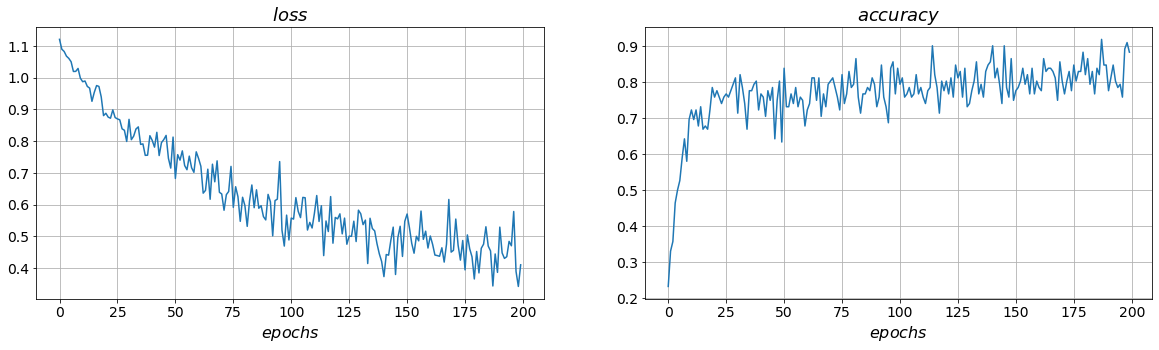

In [ ]:
# Plot result

import matplotlib.pyplot as plt

plt.figure(figsize=(20,5))
plt.subplots_adjust(wspace=0.2)

plt.subplot(1,2,1)
plt.title("$loss$",fontsize = 18)
plt.plot(losses)
plt.grid()
plt.xlabel("$epochs$", fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)


plt.subplot(1,2,2)
plt.title("$accuracy$", fontsize = 18)
plt.plot(accuracies)
plt.grid()
plt.xlabel("$epochs$", fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

plt.show()

In [ ]:
# Test

output = net(X_test)
print(torch.max(output, dim=1))
_, predicted = torch.max(output, dim=1)
accuracy = round((predicted == y_test).sum().item() / len(y_test),4)


print("test_set accuracy :", round(accuracy,4))

torch.return_types.max(
values=tensor([1.3945, 1.3722, 2.0009, 1.7509, 2.2641, 1.2397, 1.5353, 1.8058, 2.4710,
        2.1986, 1.1107, 2.0139, 1.9796, 2.0933, 2.2266, 2.3169, 2.1060, 2.3824,
        2.0023, 1.9895, 1.8090, 1.8925, 1.6113, 1.4593, 1.8539, 2.0103, 2.1267,
        2.1298, 2.2506, 1.7069, 2.0361, 0.8345, 2.0338, 1.6693, 2.8102, 2.3393,
        0.4558, 1.7679], grad_fn=<MaxBackward0>),
indices=tensor([0, 0, 0, 1, 0, 2, 2, 2, 1, 1, 1, 2, 1, 0, 0, 0, 2, 1, 2, 0, 0, 1, 2, 2,
        0, 0, 0, 0, 1, 1, 2, 2, 0, 2, 1, 0, 1, 1]))
test_set accuracy : 0.9474
